In [1]:
pip install flask tensorflow pillow numpy werkzeug


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

os.makedirs("templates", exist_ok=True)
os.makedirs("static/uploads", exist_ok=True)  # Also create the uploads folder


In [3]:
# %%writefile train_model.py
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize pixel values (0 to 1)
x_train, x_test = x_train / 255.0, x_test / 255.0

# Expand dimensions for CNN (Batch, Height, Width, Channels)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Apply data augmentation (only on training data)
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2
)
datagen.fit(x_train)

# Define the CNN model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model using augmented data
model.fit(datagen.flow(x_train, y_train, batch_size=32), validation_data=(x_test, y_test), epochs=10)

# Evaluate accuracy
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")

# Save the trained model
model.save("digit_model.h5")
print("Model saved as digit_model.h5")


E:\Anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


E:\Anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 42ms/step - accuracy: 0.7127 - loss: 0.8607 - val_accuracy: 0.9692 - val_loss: 0.0975
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 58s 31ms/step - accuracy: 0.9365 - loss: 0.2051 - val_accuracy: 0.9586 - val_loss: 0.1272
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 59s 31ms/step - accuracy: 0.9513 - loss: 0.1518 - val_accuracy: 0.9826 - val_loss: 0.0532
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 58s 31ms/step - accuracy: 0.9613 - loss: 0.1227 - val_accuracy: 0.9866 - val_loss: 0.0432
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 59s 32ms/step - accuracy: 0.9662 - loss: 0.1106 - val_accuracy: 0.9849 - val_loss: 0.0468
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 60s 32ms/step - accuracy: 0.9704 - loss: 0.0951 - val_accuracy: 0.9882 - val_loss: 0.0353
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 61s 33ms/step - accuracy: 0.9717 - loss: 0.0923 - val_accuracy: 0.9895 - val_loss: 0.0321
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 59s 31ms/step - accuracy: 0.9751 - loss: 0.08

Test Accuracy: 0.9903
Model saved as digit_model.h5


In [4]:
import os
print(os.path.exists("digit_model.h5"))  # Should print True if the model is saved


True


In [5]:
# %%writefile app.py
from flask import Flask, render_template, request
import numpy as np
import tensorflow as tf
import cv2
import os

app = Flask(__name__)

# Load the trained model
model = tf.keras.models.load_model("digit_model.h5")

# Ensure upload folder exists
UPLOAD_FOLDER = "static/uploads"
os.makedirs(UPLOAD_FOLDER, exist_ok=True)
app.config["UPLOAD_FOLDER"] = UPLOAD_FOLDER

def preprocess_image(image_path):
    """Preprocess the image for model prediction."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    
    # Ensure image is correctly oriented
    if np.mean(img) > 127:
        img = cv2.bitwise_not(img)  # Invert colors if needed

    # Resize to 28x28 and normalize
    img = cv2.resize(img, (28, 28), interpolation=cv2.INTER_AREA)
    img = img / 255.0  # Normalize to [0,1]
    
    # Expand dimensions for CNN (Batch, Height, Width, Channels)
    img = np.expand_dims(img, axis=(0, -1))

    return img

@app.route("/", methods=["GET", "POST"])
def index():
    digit = None
    filename = None

    if request.method == "POST":
        file = request.files["file"]
        if file:
            filename = file.filename
            filepath = os.path.join(app.config["UPLOAD_FOLDER"], filename)
            file.save(filepath)

            # Preprocess the image
            processed_img = preprocess_image(filepath)
            
            # Predict using the model
            prediction = model.predict(processed_img)
            digit = np.argmax(prediction)

    return render_template("index.html", filename=filename, digit=digit)

if __name__ == "__main__":
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


SystemExit: 1

E:\Anaconda3\envs\tf_env\lib\site-packages\IPython\core\interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
%%writefile templates/index.html
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Neural Network Digit Recognizer</title>
    <style>
        * {
            margin: 0;
            padding: 0;
            box-sizing: border-box;
            font-family: 'Poppins', sans-serif;
        }

        body {
            display: flex;
            justify-content: center;
            align-items: center;
            height: 100vh;
            background: black;
            overflow: hidden;
            color: white;
        }

        /* Starry Animated Background */
        .stars {
            position: fixed;
            width: 100%;
            height: 100%;
            background: url('https://i.imgur.com/Vy7yEhp.png');
            animation: animateStars 50s linear infinite;
        }

        @keyframes animateStars {
            from { background-position: 0 0; }
            to { background-position: -10000px 5000px; }
        }

        .container {
            position: relative;
            background: rgba(255, 255, 255, 0.1);
            padding: 30px;
            border-radius: 12px;
            backdrop-filter: blur(10px);
            box-shadow: 0 4px 10px rgba(255, 255, 255, 0.2);
            text-align: center;
            z-index: 2;
        }

        h1 {
            color: #ffcc00;
            margin-bottom: 10px;
            font-size: 28px;
        }

        h2 {
            margin-bottom: 15px;
            font-size: 24px;
            color: #ffcc00;
        }

        input[type="file"] {
            display: none;
        }

        .custom-file-upload {
            display: inline-block;
            padding: 12px 24px;
            background: linear-gradient(135deg, #ffcc00, #ff6600);
            color: black;
            border-radius: 8px;
            cursor: pointer;
            font-weight: bold;
            transition: 0.3s;
        }

        .custom-file-upload:hover {
            background: linear-gradient(135deg, #ff6600, #ffcc00);
        }

        .submit-btn {
            display: block;
            margin-top: 20px;
            padding: 12px 24px;
            background: linear-gradient(135deg, #00ccff, #0066ff);
            color: white;
            border-radius: 8px;
            border: none;
            cursor: pointer;
            font-weight: bold;
            transition: 0.3s;
        }

        .submit-btn:hover {
            background: linear-gradient(135deg, #0066ff, #00ccff);
        }

        img {
            margin-top: 15px;
            width: 150px;
            border-radius: 8px;
            border: 2px solid white;
        }
    </style>
</head>
<body>
    <div class="stars"></div>
    <div class="container">
        <h1>Neural Network Digit Recognizer</h1>
        <h2>Upload an Image of a Digit (PNG with Black Background)</h2>
        <form action="/" method="post" enctype="multipart/form-data" onsubmit="return validateFile()">
            <label class="custom-file-upload">
                <input type="file" id="fileInput" name="file" accept="image/png" required>
                Choose Image
            </label>
            <input type="submit" class="submit-btn" value="Predict">
        </form>

        <script>
            function validateFile() {
                const fileInput = document.getElementById('fileInput');
                const file = fileInput.files[0];
                
                if (!file) {
                    alert("Please upload a PNG image with a black background.");
                    return false;
                }

                if (file.type !== 'image/png') {
                    alert("Only PNG images are allowed!");
                    return false;
                }

                return true;
            }
        </script>

        {% if filename %}
        <h3>Uploaded Image:</h3>
        <img src="{{ url_for('static', filename='uploads/' + filename) }}" alt="Uploaded Image">
        <h3>Predicted Digit: {{ digit }}</h3>
        {% endif %}
    </div>
</body>
</html>




Overwriting templates/index.html


In [7]:
import sys
print(sys.executable)
print(sys.version)


E:\Anaconda3\envs\tf_env\python.exe
3.10.16 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:19:12) [MSC v.1929 64 bit (AMD64)]


In [10]:
%matplotlib inline


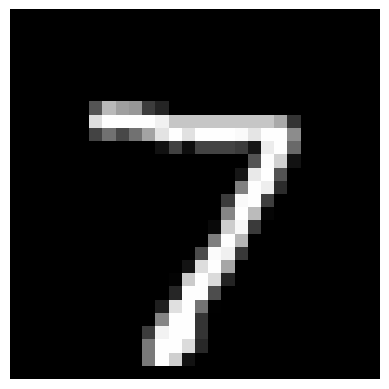

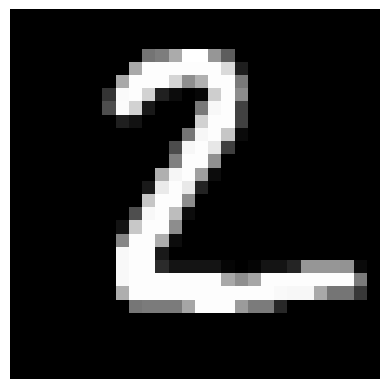

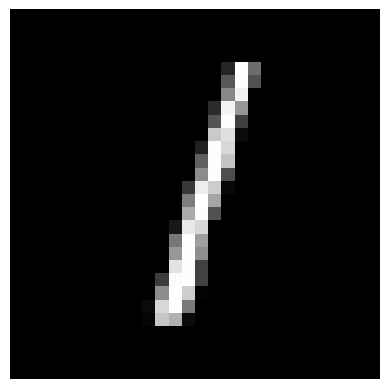

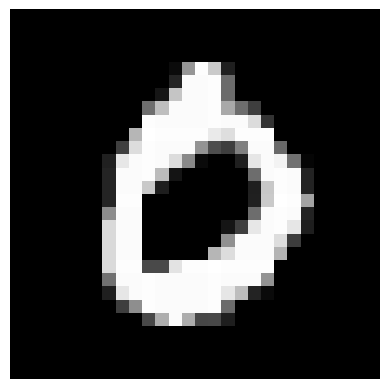

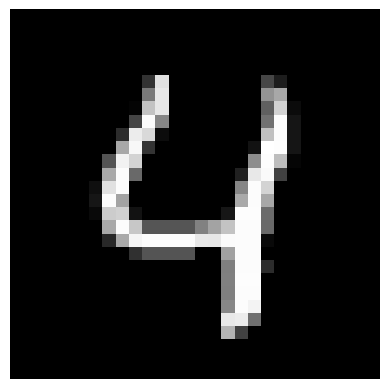

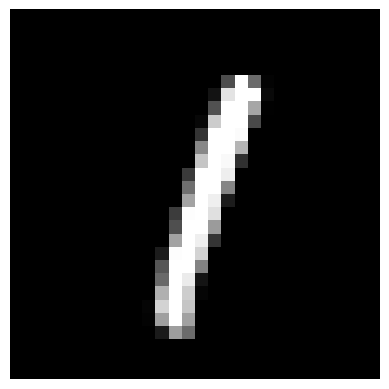

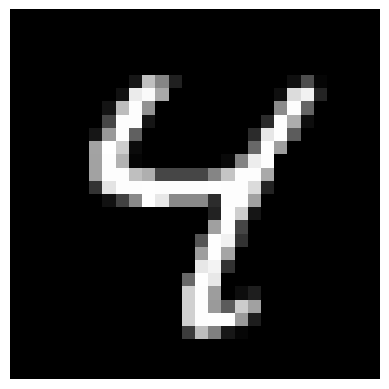

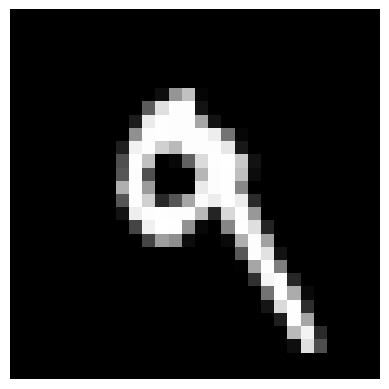

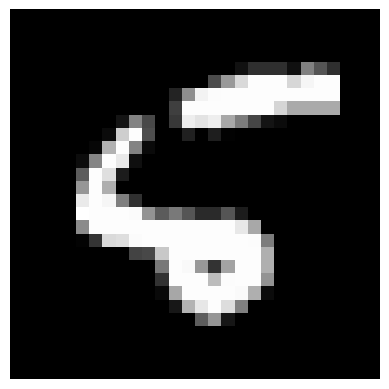

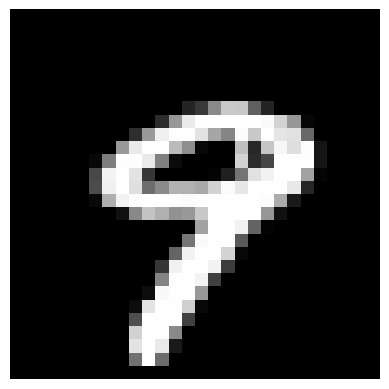

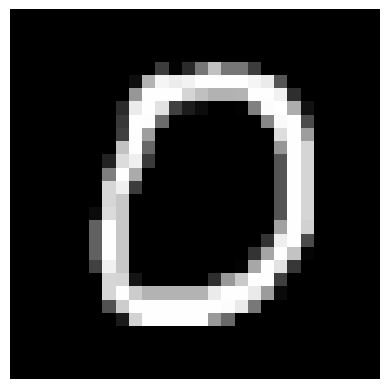

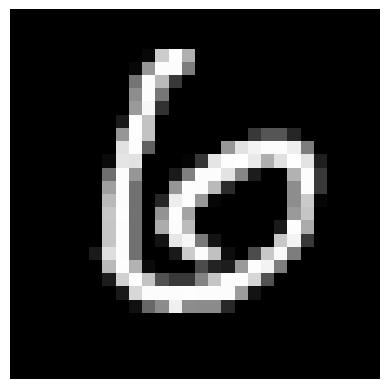

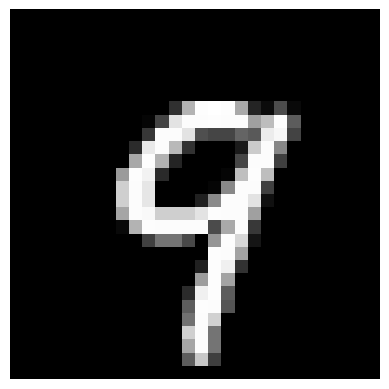

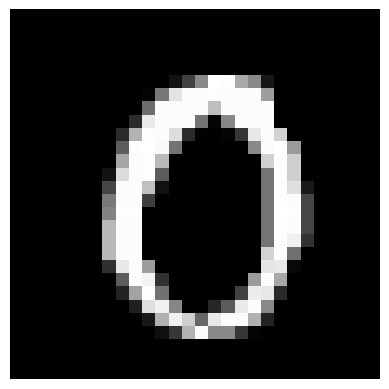

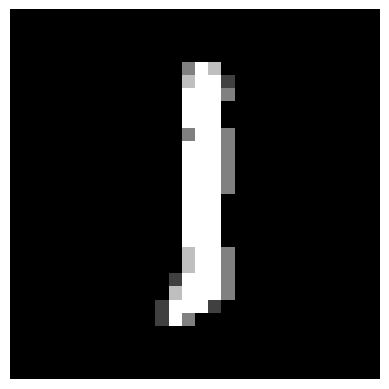

In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Save and display a few sample images
for i in range(15):  # Save 5 sample images
    plt.imshow(x_test[i], cmap="gray")
    plt.axis("off")
    plt.savefig(f"digit_{i}.png", bbox_inches="tight", pad_inches=0)
    plt.show(block=True)  # Force display


In [ ]:
#Run on Anaconda Prompt By python app.py